<a href="https://colab.research.google.com/github/Binhcore/I2D/blob/main/Edit%5BSKELETON%5D_Lecture_2_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
import os
import pickle

# To see the progress
from tqdm.notebook import tqdm

import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Things related to the pytorch
import torch                                        # main pytorch package
import torch.nn as nn                               # pytorch module for neural network
from torch.utils.data import Dataset, DataLoader    # pytorch utils for dataset

# Make the dataset! add noise to the linear function
- gt_w, gt_b : ground truth weight and bias for linear regression
- x : random points
- y : gt_w * x + gt_b + (gaussian) noise

[-1  1]


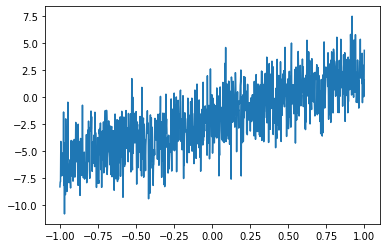

In [2]:
### make the linear dataset. Define the gt_w and gt_b as you want
gt_w = 4.0
gt_b = -2.0

### define the number of data, and value of noise to add to wx+b.
num_data = 1000
noise_value = 2

### Sample some random X between range -1~1 / or range you want..
x_range = np.array([-1,1])
print(x_range)
x = np.linspace(x_range[0], x_range[1], num_data)


### Define some noise to add to wx+b
noise = noise_value * np.random.randn(num_data) # num_data dimensional vector
y = gt_w * x +gt_b + noise
plt.plot(x,y)

[-1  1]
[-6.  2.]


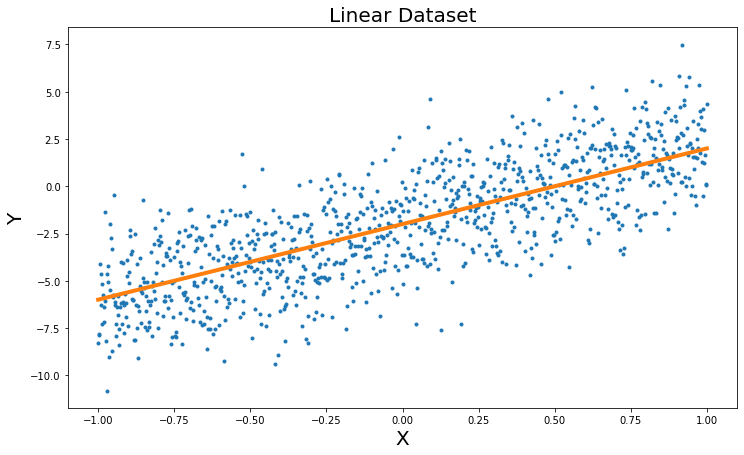

In [8]:
### Plot the dataset
plt.figure(figsize=(12, 7))
plt.plot(x, y, '.')

### Plot the ground truth linear regressor
plt.plot(x_range, x_range * gt_w + gt_b, linewidth=4)
print(x_range) # x
print(x_range * gt_w + gt_b) # y

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

# Define the Pytorch Dataset with x y points
- Define your own class, which inherits from "Dataset" class of pytorch
- Define constructor of the class with init
- Define the length of the dataset with len
- Define the function when bringing out the idx-th dataset
    * Return the dictionary containing the input and output of single datapoint


In [14]:
class XY_Dataset(Dataset):
    def __init__(self, x, y):
        '''
        x : input points
        y : output points
        '''
        self.x = x
        self.y = y
        self.num_data = x.shape[0]
        pass

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        curr_x = self.x[idx]
        curr_y = self.y[idx]

        sample = dict()
        sample['x'] = curr_x
        sample['y'] = curr_y

        return sample

In [24]:
sample_dataset = XY_Dataset(x,y)
#sample_dataset[0]
#sample_dataset[-1]
#print(len(sample_dataset))
#print(sample_dataset.num_data)

{'x': -1.0, 'y': -8.301103342232281}

# Define the dataset, and dataloader
- DataLoader makes you to randomly sample the dataset with a batch size you want.

In [30]:
### Define the batch size you want
batch_size = 64

### Create the instance of dataset, and dataloader
dataset = XY_Dataset(x,y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Try sampling out one random data point.
sample = next(iter(dataloader))
#print(sample)
#print(sample['x'])

# Initialize the weight and bias.

In [115]:
### Needs requires_grad=True, if you want to make as a parameter to train.
pred_w = torch.randn(1, requires_grad=True)
pred_b = torch.randn(1, requires_grad=True)
print('Initialized w: {}, b: {}'.format(pred_w.item(), pred_b.item()))
#optimizer = torch.optim.Adam([pred_w, pred_b], lr=1e-3)

Initialized w: -1.5437216758728027, b: -0.36311861872673035


# Define the ,,train'' function. 

In [116]:
def train(pred_w, pred_b, sample, learning_rate):
    '''
    pred_w : weight to train.
    pred_b : bias to train.
    sample : sample from dataloader. dictionary containing 'x' and 'y'.
    learning_rate : the learning rate you want. 
    pred_loss : predicted loss from this iteration
    '''
    
    # get prediction
    pred_y = sample['x'] * pred_w + pred_b
    
    # calculate the pred_loss
    criteria = nn.MSELoss()
    pred_loss = criteria(pred_y, sample['y'])
    #pred_loss = torch.mean(torch.norm(pred_y-sample['y'], p=2))
    
    # make pytorch compute the gradient
    pred_loss.backward()

    # need ``no_grad'' to keep the computed gradient. otherwise, it will generate NoneType
    with torch.no_grad():
        pred_w -= learning_rate * pred_w.grad
        pred_b -= learning_rate * pred_b.grad
        
    # initizlize the gradient to zero
    pred_w.grad.zero_()
    pred_b.grad.zero_()
    
    return pred_loss.item()

In [117]:
train(pred_w, pred_b, sample, learning_rate = 0.1)

17.301827224669346

# Iterate over the dataset! With your ,,train'' function

In [118]:
# define the maximum epoch
max_epoch = 1000

# define a list to save the loss
loss_saver = list()

# define how often you will print the result
print_stride = 50

# iterate over the dataset for (max_epoch) times
for epoch in tqdm(range(max_epoch)):
    total_loss = 0.0
    for idx, sample in enumerate(dataloader):
        curr_loss = train(pred_w, pred_b, sample, learning_rate = 0.1)
        total_loss += curr_loss / len(dataloader)
    loss_saver.append(total_loss)
    if (epoch+1)%print_stride == 0:
        print('EPOCH : {}, Loss : {}, pred_w : {}, pred_b : {}'.format(epoch+1, total_loss, pred_w.item(), pred_b.item()))
    
print()
print('Final Prediction : pred_w = {}, pred_b = {}'.format(pred_w.item(), pred_b.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH : 50, Loss : 3.9412952242328827, pred_w : 4.228423118591309, pred_b : -1.891449213027954
EPOCH : 100, Loss : 3.9382958976627367, pred_w : 4.222720623016357, pred_b : -2.08543062210083
EPOCH : 150, Loss : 3.931580738704171, pred_w : 4.28866720199585, pred_b : -2.063483238220215
EPOCH : 200, Loss : 3.9471092824816045, pred_w : 4.178511142730713, pred_b : -2.0242090225219727
EPOCH : 250, Loss : 3.9476188813799107, pred_w : 4.231903076171875, pred_b : -1.952446460723877
EPOCH : 300, Loss : 3.964784716334106, pred_w : 4.204765796661377, pred_b : -2.0594499111175537
EPOCH : 350, Loss : 3.9606045692457186, pred_w : 4.1857099533081055, pred_b : -1.9495140314102173
EPOCH : 400, Loss : 3.9289747585636796, pred_w : 4.217591762542725, pred_b : -2.028240203857422
EPOCH : 450, Loss : 3.952596645803933, pred_w : 4.226825714111328, pred_b : -1.982431411743164
EPOCH : 500, Loss : 3.9223544148037717, pred_w : 4.305179595947266, pred_b : -1.9886566400527954
EPOCH : 550, Loss : 3.969877753258894, pr

# Plot the result : training loss and resulted linear regressor

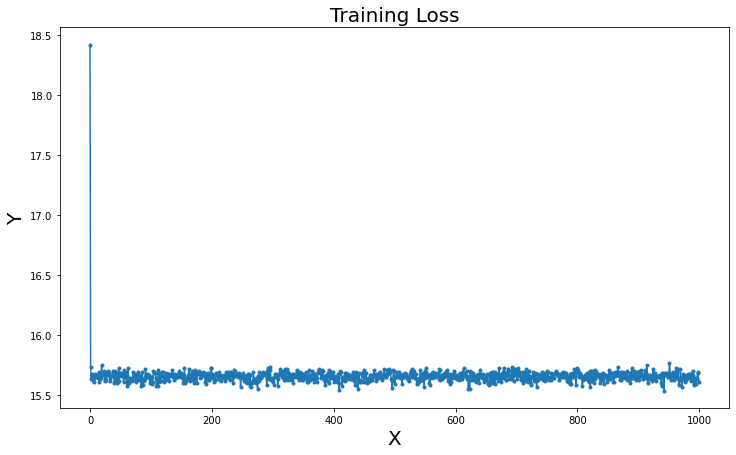

In [107]:
loss_saver = np.array(loss_saver)
plt.figure(figsize=(12, 7))
plt.plot(np.arange(len(loss_saver)), loss_saver, '.-')
plt.title('Training Loss', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

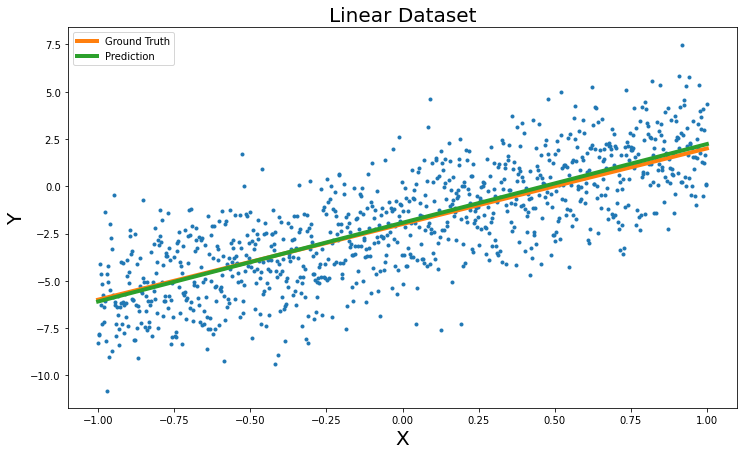

In [108]:
plt.figure(figsize=(12, 7))

### Plot the dataset
plt.plot(x, y, '.')

### Plot the ground truth + predicted linear regressor
plt.plot(x_range, x_range * gt_w + gt_b, linewidth=4, label='Ground Truth')
plt.plot(x_range, x_range * pred_w.item() + pred_b.item(), linewidth=4, label='Prediction')

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.legend()
plt.show()